In [21]:
import psycopg2
import pandas as pd 
# from sqlalchemy.types import Integer, Text, String, DateTime
import sqlalchemy as salc
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = s.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [22]:
repo_list = pd.DataFrame()
repo_list_query = f"""
SELECT repo_id, repo_name, repo_path from repo
WHERE repo_name = 'concourse' OR repo_name = 'postfacto' or repo_name = 'clarity' or repo_name = 'gpdb' or
      repo_name = 'kpack' or repo_name = 'rabbitmq-server' or repo_name = 'sonobuoy';
    """
repo_list = pd.read_sql_query(repo_list_query, con=engine)
print(repo_list)

   repo_id        repo_name                              repo_path
0    26235        concourse               github.com/pcfdev-forks/
1    28051        concourse                  github.com/concourse/
2    28030         sonobuoy               github.com/vmware-tanzu/
3    27913          clarity                     github.com/vmware/
4    26983        postfacto                    github.com/pivotal/
5    27169             gpdb                github.com/pivotal-gss/
6    25857             gpdb               github.com/greenplum-db/
7    25432  rabbitmq-server                   github.com/rabbitmq/
8    26600             gpdb  github.com/Pivotal-Field-Engineering/
9    27043            kpack                    github.com/pivotal/


In [157]:
## List of repository IDs for the report
#repo_dict = {25760, 25663} #spring-boot & spring-framework
#repo_dict = {28051} # concourse
repo_dict = {26983} #postfacto
#repo_dict = {25432} #rabbitmq-server
#repo_dict = {25663} #spring-framework
#repo_dict = {28030} #sonobuoy
#repo_dict = {28031} #velero

In [158]:
#from datetime import date
import datetime 

current = datetime.date.today()
today = "'" + str(current) + "'"
print(today)

first_current = current.replace(day=1)
last_month = first_current - datetime.timedelta(days=1)
end_date = "'" + str(last_month) + "'"
print(end_date)

print

start = last_month - datetime.timedelta(days=365)
year_ago = "'" + str(start) + "'"
print(year_ago)

'2020-03-18'
'2020-02-29'
'2019-03-01'


In [159]:
pr_all = pd.DataFrame()

for repo_id in repo_dict: 

    pr_query = salc.sql.text(f"""
                    SELECT
                        repo.repo_id AS repo_id,
                        pull_requests.pr_src_id AS pr_src_id,
                        repo.repo_name AS repo_name,
                        pr_src_author_association,
--                         repo_groups.rg_name AS repo_group,
                        pull_requests.pr_src_state,
                        pull_requests.pr_merged_at,
                        pull_requests.pr_created_at AS pr_created_at,
                        pull_requests.pr_closed_at AS pr_closed_at,
                        date_part( 'year', pr_created_at :: DATE ) AS CREATED_YEAR,
                        date_part( 'month', pr_created_at :: DATE ) AS CREATED_MONTH,
						   date_part( 'year', pr_closed_at :: DATE ) AS CLOSED_YEAR,
                        date_part( 'month', pr_closed_at :: DATE ) AS CLOSED_MONTH,
                        ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_close,
                        ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_close, 
                        ( EXTRACT ( EPOCH FROM first_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_first_response,
                        ( EXTRACT ( EPOCH FROM first_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_first_response, 
                        ( EXTRACT ( EPOCH FROM last_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_last_response,
                        ( EXTRACT ( EPOCH FROM last_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_last_response, 
--                         pull_requests.pr_html_url AS pr_url, pull_requests.pr_src_title AS pr_title,
                        first_response_time,
                        last_response_time,
                        average_time_between_responses,
                        assigned_count,
                        review_requested_count,
                        labeled_count,
                        subscribed_count,
                        mentioned_count,
                        referenced_count,
                        closed_count,
                        head_ref_force_pushed_count,
                        merged_count,
                        milestoned_count,
                        unlabeled_count,
                        head_ref_deleted_count,
                        comment_count--,
                       -- lines_of_code_added, 
                       -- commit_count, 
                       -- file_count
                    FROM
                        repo,
                        repo_groups,
                        pull_requests,
                        ( 
                            SELECT pull_requests.pull_request_id,
                            count(*) FILTER (WHERE action = 'assigned') AS assigned_count,
                            count(*) FILTER (WHERE action = 'review_requested') AS review_requested_count,
                            count(*) FILTER (WHERE action = 'labeled') AS labeled_count,
                            count(*) FILTER (WHERE action = 'unlabeled') AS unlabeled_count,
                            count(*) FILTER (WHERE action = 'subscribed') AS subscribed_count,
                            count(*) FILTER (WHERE action = 'mentioned') AS mentioned_count,
                            count(*) FILTER (WHERE action = 'referenced') AS referenced_count,
                            count(*) FILTER (WHERE action = 'closed') AS closed_count,
                            count(*) FILTER (WHERE action = 'head_ref_force_pushed') AS head_ref_force_pushed_count,
                            count(*) FILTER (WHERE action = 'head_ref_deleted') AS head_ref_deleted_count,
                            count(*) FILTER (WHERE action = 'milestoned') AS milestoned_count,
                            count(*) FILTER (WHERE action = 'merged') AS merged_count,
                            MIN(message.msg_timestamp) AS first_response_time,
                            COUNT(DISTINCT message.msg_timestamp) AS comment_count,
                            MAX(message.msg_timestamp) AS last_response_time,
                            (MAX(message.msg_timestamp) - MIN(message.msg_timestamp)) / COUNT(DISTINCT message.msg_timestamp) AS average_time_between_responses

                            FROM pull_request_events, pull_requests, repo, pull_request_message_ref, message
                            WHERE repo.repo_id = {repo_id}
                            AND repo.repo_id = pull_requests.repo_id
                            AND pull_requests.pull_request_id = pull_request_events.pull_request_id
                            AND pull_requests.pull_request_id = pull_request_message_ref.pull_request_id
                            AND pull_request_message_ref.msg_id = message.msg_id

                            GROUP BY pull_requests.pull_request_id
                        ) response_times--,
                        /*(
                            SELECT sum(cmt_added) AS lines_of_code_added, pull_request_id, count(DISTINCT cmt_commit_hash) AS commit_count, count(DISTINCT cmt_filename) AS file_count
                            FROM (
                                SELECT pr_cmt_id, cmt_added, pull_request_commits.pull_request_id, cmt_commit_hash, cmt_filename
                                FROM pull_request_commits, commits, pull_requests, pull_request_meta
                                WHERE cmt_commit_hash = pr_cmt_sha
                                AND pull_requests.pull_request_id = pull_request_commits.pull_request_id
                                AND pull_requests.pull_request_id = pull_request_meta.pull_request_id
                                AND pull_request_meta.pr_head_or_base = 'base' AND pr_src_meta_label LIKE '%master'
                                AND pull_requests.repo_id = {repo_id}
                                AND commits.repo_id = pull_requests.repo_id
                                AND commits.cmt_commit_hash <> pull_requests.pr_merge_commit_sha
                            ) AS pr_cmt_info
                            GROUP BY pull_request_id
                        ) counts*/
                    WHERE repo.repo_group_id = repo_groups.repo_group_id 
                        AND repo.repo_id = pull_requests.repo_id 
                        AND repo.repo_id = {repo_id} 
                        AND pr_created_at >= {year_ago}
                        AND pr_created_at <= {end_date}
                        AND response_times.pull_request_id = pull_requests.pull_request_id
                       -- AND counts.pull_request_id = pull_requests.pull_request_id
                    ORDER BY
                       merged_count DESC

        """)
    pr_a = pd.read_sql(pr_query, con=engine)
    if not pr_all.empty: 
        pr_all = pd.concat([pr_all, pr_a]) 
    else: 
        # first repo
        pr_all = pr_a

In [173]:
pr_all['diff'] = pr_all.first_response_time - pr_all.pr_created_at
pr_all['month'] = pr_all['pr_created_at'].dt.strftime('%b')
pr_all['diff_days'] = pr_all['diff'] / datetime.timedelta(days=1)
print(pr_all['diff_days'],pr_all['month'],pr_all['diff'])

#group = pr_small.groupby(pd.Grouper(key='pr_created_at', freq='1M')).count()
#group.index = group.index.strftime('%B')

#group = pr_small.groupby(pd.Grouper(key='pr_created_at', freq="M"))
#count = group['diff'].count()
#summer = group['diff'].sum()
#count.index = count.index.strftime('%B')
#summer.index = summer.index.strftime('%B')
#months = pd.Series(count.index)
#counts = pd.Series(count)
#print(months, counts)

#summer_df = summer.to_frame()
#count_df = count.to_frame()
#new_df = pd.concat([summer_df, count_df], axis=1)
#new_df.reset_index()
#new_df.columns = ['diff_sum', 'diff_count']
#new_df['avg_first_response'] = new_df['diff_sum']/new_df['diff_count']

#display(count, summer)
#print(new_df)

0      27.860486
1       0.000023
2       3.184641
3       0.000023
4       0.000023
5       2.933079
6       0.000023
7       0.056435
8       1.659664
9       0.001933
10      4.037118
11      0.000023
12      0.000023
13     13.125602
14     12.234815
15      0.001725
16      2.692836
17     20.041678
18      0.123819
19      0.890336
20      0.000972
21      0.000023
22      0.000012
23      3.718368
24    113.227604
25      0.000023
26      0.004039
27      1.829641
28      0.000023
29      0.000023
30      0.000023
31      0.580104
32      0.000023
33      0.000035
34     22.192419
35      0.000023
36      0.000035
37      0.000023
38      0.018449
39      0.000012
40      0.000023
Name: diff_days, dtype: float64 0     Aug
1     Jul
2     May
3     Jul
4     Sep
5     Aug
6     Aug
7     Jul
8     Jul
9     Jul
10    Jul
11    Aug
12    Sep
13    Jun
14    Nov
15    Oct
16    Mar
17    May
18    Aug
19    Oct
20    Oct
21    Jun
22    Sep
23    May
24    Mar
25    Oct
26    Oct
2

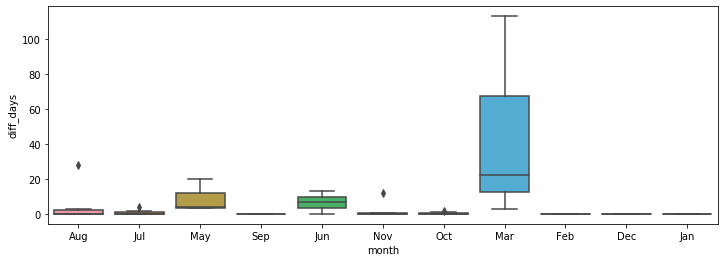

In [174]:
fig, ax = plt.subplots()
fig.set_size_inches((12,4))
my_plot = sns.boxplot(x='month', y='diff_days', data=pr_all, ax=ax)

In [17]:
# time to first response for PRs

pr_first_responseDF = pd.DataFrame()
for value in repo_dict: 
    pr_first_response_query = f"""
                SELECT
                    repo.repo_id,
                    pull_requests.pr_src_id,
                    pull_requests.pr_src_state,
                    pull_requests.pr_merged_at,
                    pull_requests.pr_created_at,
                    pull_requests.pr_closed_at,
                    MIN(message.msg_timestamp),
                    COUNT(DISTINCT message.msg_timestamp),
                    MAX(message.msg_timestamp)
                FROM
                    pull_requests, pull_request_message_ref, repo, message
                WHERE
                    repo.repo_id = {value}
                    AND pull_request_message_ref.msg_id = message.msg_id
                    AND repo.repo_id = pull_requests.repo_id
                    AND pull_requests.pull_request_id = pull_request_message_ref.pull_request_id
                GROUP BY
                    repo.repo_id;
                """
    
    get_repo_name_query = f"""
        SELECT repo_name from repo where repo_id = {value};
           """
    get_repo_name = pd.read_sql_query(get_repo_name_query, con=engine)
    repo_name = get_repo_name.repo_name[0]
    
pr_first_responseDF = pd.read_sql_query(pr_first_response_query, con=engine)
print(pr_first_responseDF)

ProgrammingError: (psycopg2.errors.GroupingError) column "pull_requests.pr_src_id" must appear in the GROUP BY clause or be used in an aggregate function
LINE 4:                     pull_requests.pr_src_id,
                            ^

[SQL: 
                SELECT
                    repo.repo_id,
                    pull_requests.pr_src_id,
                    pull_requests.pr_src_state,
                    pull_requests.pr_merged_at,
                    pull_requests.pr_created_at,
                    pull_requests.pr_closed_at,
                    MIN(message.msg_timestamp),
                    COUNT(DISTINCT message.msg_timestamp),
                    MAX(message.msg_timestamp)
                FROM
                    pull_requests, pull_request_message_ref, repo, message
                WHERE
                    repo.repo_id = 25663
                    AND pull_request_message_ref.msg_id = message.msg_id
                    AND repo.repo_id = pull_requests.repo_id
                    AND pull_requests.pull_request_id = pull_request_message_ref.pull_request_id
                GROUP BY
                    repo.repo_id;
                ]
(Background on this error at: http://sqlalche.me/e/f405)